In [274]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import time

bottleneck_size = 512
bottleneck_size_2 = 8*64

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, bottleneck_size),
            nn.ReLU(),
            nn.Linear(bottleneck_size, bottleneck_size),
            nn.ReLU(),
            nn.Linear(bottleneck_size, bottleneck_size),
            nn.ReLU(),
            nn.Linear(bottleneck_size, bottleneck_size),
            nn.ReLU(),
            nn.Linear(bottleneck_size, bottleneck_size_2),
            nn.ReLU(),
            nn.Linear(bottleneck_size_2, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

import os
import pandas as pd
from torchvision.io import decode_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

from torch.utils.data import DataLoader


In [58]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0121,  0.0123, -0.0223,  ..., -0.0288, -0.0283,  0.0166],
        [-0.0301, -0.0341, -0.0260,  ..., -0.0284, -0.0020,  0.0100]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([0.0280, 0.0231], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0195,  0.0023, -0.0431,  ..., -0.0109, -0.0075,  0.0051],
        [ 0.0338,  0.0338,  0.0187,  ...,  0.0360, -0.0326,  0.0301]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Si

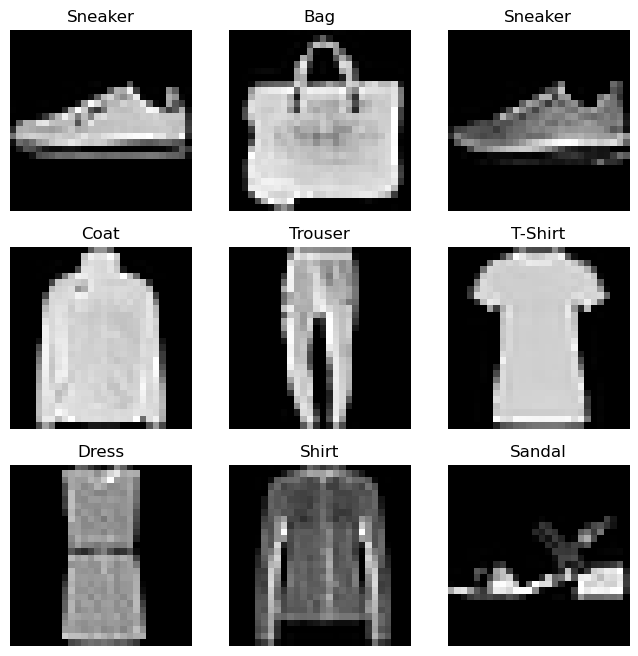

In [24]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


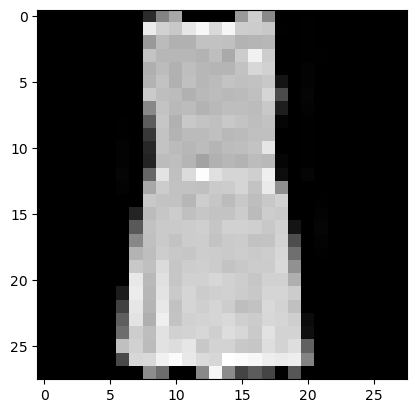

Label: 3


In [60]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [112]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        #X = X.to(device)
        #y = y.to(device)
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            #X = X.to(device)
            #y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [276]:
learning_rate = 19e-3
batch = 64
epochs = 275

device = 'mps'

train_dataloader = DataLoader(training_data, batch_size=batch, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch, shuffle=True)

model = NeuralNetwork().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for x, y in train_dataloader:
    x  = x.to(device)
    y = y.to(device)
    # Rest of training loop

t_start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

t_elapsed = time.time() - t_start
print(f"t_elapsed = {t_elapsed:.1f} sec")

Epoch 1
-------------------------------
loss: 2.307223  [   64/60000]
loss: 2.301068  [ 6464/60000]
loss: 2.299096  [12864/60000]
loss: 2.293298  [19264/60000]
loss: 2.281187  [25664/60000]
loss: 2.263267  [32064/60000]
loss: 2.173970  [38464/60000]
loss: 1.836459  [44864/60000]
loss: 1.275470  [51264/60000]
loss: 1.196997  [57664/60000]
Test Error: 
 Accuracy: 54.6%, Avg loss: 1.160946 

Epoch 2
-------------------------------
loss: 1.217604  [   64/60000]
loss: 0.922880  [ 6464/60000]
loss: 0.925605  [12864/60000]
loss: 1.120956  [19264/60000]
loss: 0.714061  [25664/60000]
loss: 1.071122  [32064/60000]
loss: 0.965061  [38464/60000]
loss: 0.953073  [44864/60000]
loss: 0.803259  [51264/60000]
loss: 0.692759  [57664/60000]
Test Error: 
 Accuracy: 68.0%, Avg loss: 0.871453 

Epoch 3
-------------------------------
loss: 0.736064  [   64/60000]
loss: 0.942766  [ 6464/60000]
loss: 0.736980  [12864/60000]
loss: 0.800925  [19264/60000]
loss: 0.614935  [25664/60000]
loss: 0.589803  [32064/600